# Data loading

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm_notebook

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [ ]:
df_time = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ts_data_students.xlsx', sheet_name='final time', usecols='Z', names=['Time'], parse_dates=['Time'])

In [ ]:
df_time.head()

,Time
0,2018-05-10 00:00:00
1,2018-05-10 01:00:00
2,2018-05-10 02:00:00
3,2018-05-10 03:00:00
4,2018-05-10 04:00:00


In [ ]:
df_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ts_data_students.xlsx', sheet_name='final data', usecols='Z', names=['Data'])

In [ ]:
df_data.head()

,Data
0,63245.526621
1,63074.069365
2,67288.326587
3,72938.032239
4,81805.591482


In [ ]:
dataset = df_time.copy()
dataset['Data'] = df_data['Data']

In [ ]:
dataset.head()

,Time,Data
0,2018-05-10 00:00:00,63245.526621
1,2018-05-10 01:00:00,63074.069365
2,2018-05-10 02:00:00,67288.326587
3,2018-05-10 03:00:00,72938.032239
4,2018-05-10 04:00:00,81805.591482


In [ ]:
dataset.to_excel('/content/drive/MyDrive/Colab Notebooks/my_ts_data.xlsx', index=False)

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_ts_data.xlsx', index_col='Time', parse_dates=['Time'])

In [ ]:
data.head()

,Data
Time,
2018-05-10 00:00:00,63245.526621
2018-05-10 01:00:00,63074.069365
2018-05-10 02:00:00,67288.326587
2018-05-10 03:00:00,72938.032239
2018-05-10 04:00:00,81805.591482


Загруженные данные имеют следующий вид:

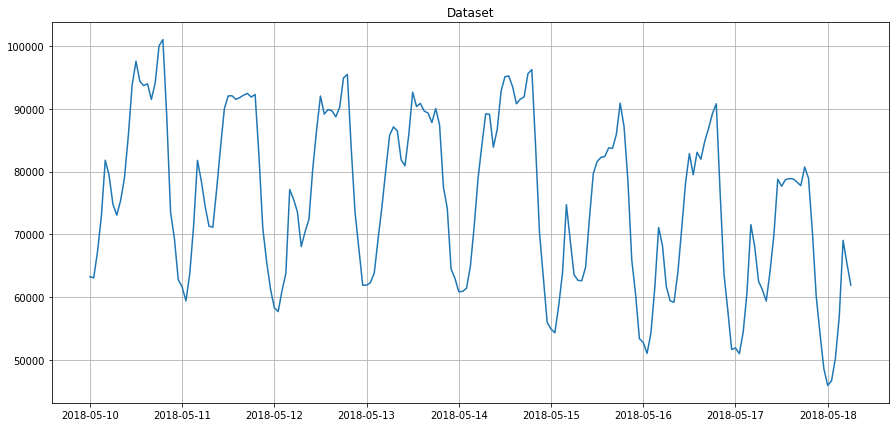

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data.Data)
plt.title('Dataset')
plt.grid(True)
plt.show()

Добавим отрисовку с помошью plotly.

In [ ]:
plotly_df(data)

# Predicting with ARIMA

Построим ARIMA модель, приведя ряд к стационарному виду.

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000001


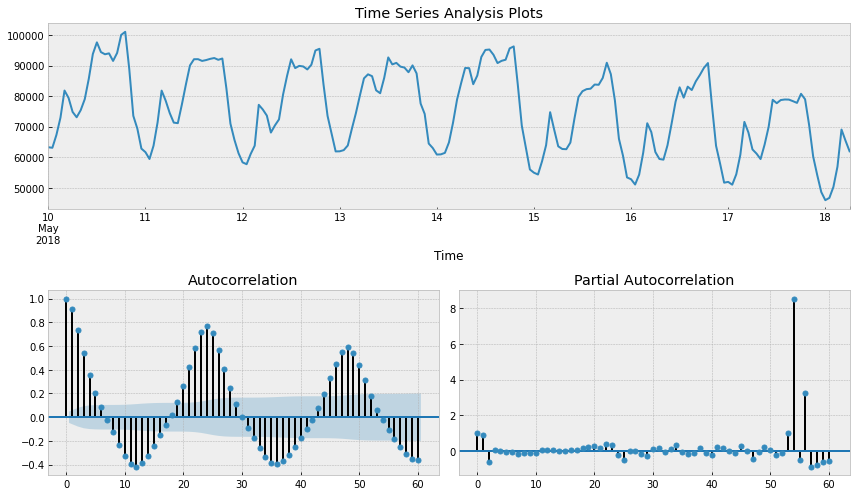

In [ ]:
tsplot(data.Data, lags=60)

Исходные серии стационарны; тест Дики-Фуллера отверг нулевую гипотезу о наличии единичного корня. Фактически, мы можем видеть это на самом графике - у нас нет видимого тренда, поэтому среднее значение постоянно, а дисперсия в значительной степени стабильна. Остается только сезонность, с которой мы должны разбираться до моделирования.

Для этого вычтем ряд из самого себя с "лагом", равным сезонному периоду.

Критерий Дики-Фуллера: p=0.075013


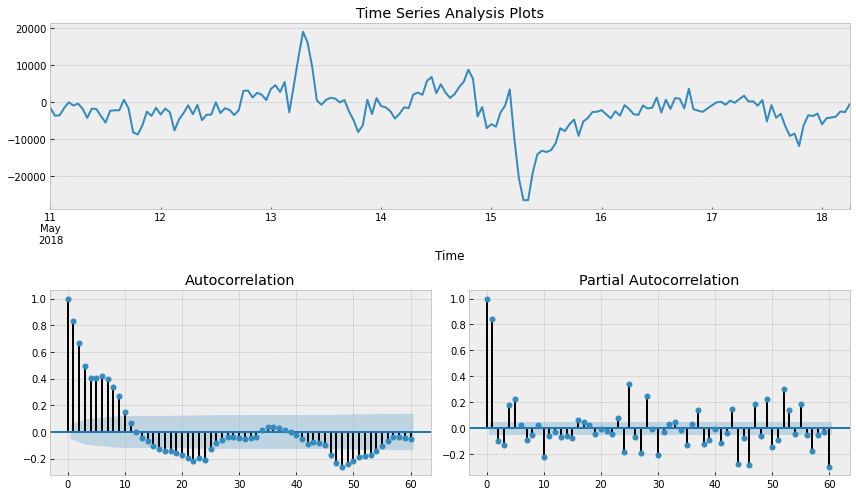

In [ ]:
data_diff = data.Data - data.Data.shift(24)
tsplot(data_diff[24:], lags=60)

Ситуация стала намного лучше, исчезла видимая сезонность. Однако автокорреляционная функция по-прежнему имеет слишком много значительных "лагов". Чтобы удалить их, мы вычтем ряд из себя с "лагом" 1.

Критерий Дики-Фуллера: p=0.000000


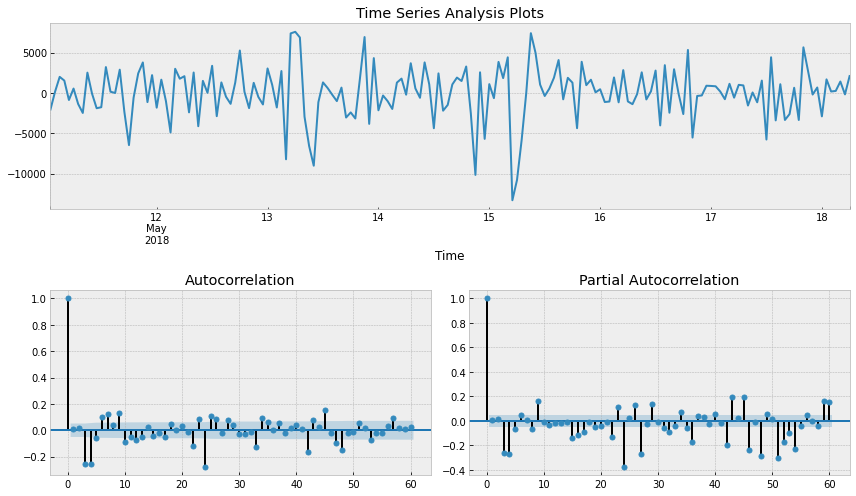

In [ ]:
data_diff = data_diff - data_diff.shift(1)
tsplot(data_diff[24+1:], lags=60)

Тест Дики-Фуллера показывает, что ряд стационарный, и количество значимых пиков в уменьшилось. Можно приступать к моделированию.

## Model

Протестируем разные модели и посмотрим, какая из них лучше.

In [ ]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(data.Data, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 7min 37s, sys: 5min 20s, total: 12min 58s
Wall time: 6min 35s


In [ ]:
result_table.head()

,parameters,aic
0,"(2, 2, 1, 1)",3279.379707
1,"(3, 2, 1, 1)",3279.645523
2,"(2, 3, 1, 1)",3279.785736
3,"(4, 2, 1, 1)",3281.258768
4,"(3, 3, 1, 1)",3281.408131


In [ ]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data.Data, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               Data   No. Observations:                  199
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 24)   Log Likelihood               -1632.690
Date:                            Sat, 20 Mar 2021   AIC                           3279.380
Time:                                    14:36:06   BIC                           3301.493
Sample:                                05-10-2018   HQIC                          3288.350
                                     - 05-18-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0717      0.151      7.076      0.000       0.775       1.369
ar.L2         -0.8146      0.139   

Критерий Дики-Фуллера: p=0.000000


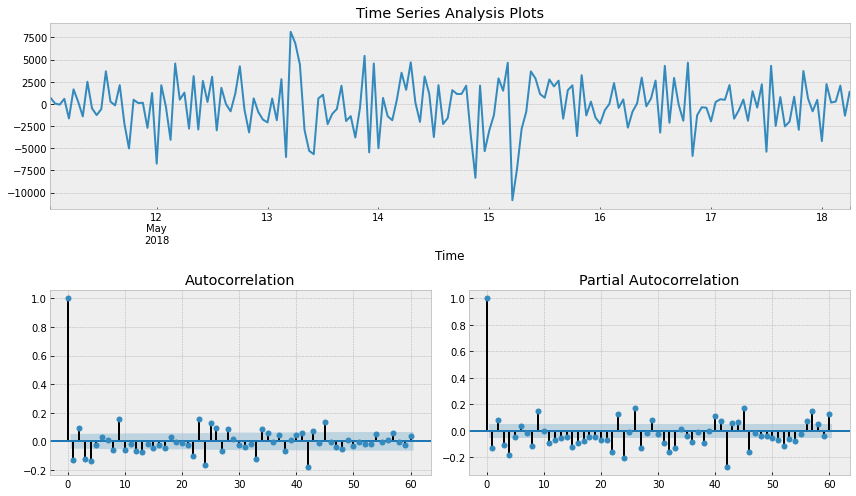

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

Сделаем прогнозы, используя нашу модель.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotSARIMA(series, model, n_steps):
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

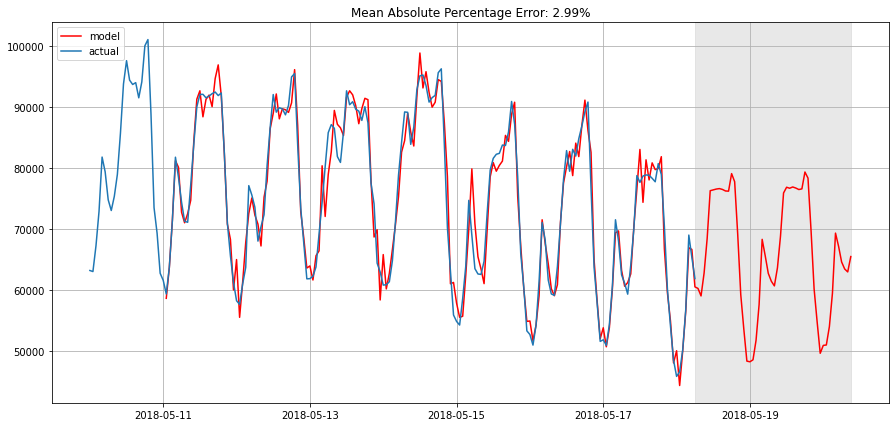

In [ ]:
plotSARIMA(data, best_model, 50)

В итоге мы получили хорошие прогнозы. Наша модель ошибалась в среднем на 2,99%.